# Regression Models with Time Series Errors: 1 Year Rate vs 3 Year Rate

By Jackson Barkstrom, based on *Analysis of Financial Time Series* by Ruey Tsay. Data from the Federal Reserve.

In [2]:
import pandas as pd
import statsmodels.api as sm

In [3]:
r1t = pd.read_csv('w-gs1yr.txt',
                       delimiter='  ')
r3t = pd.read_csv('w-gs3yr.txt',
                       delimiter='  ')

/Users/jwbarkstrom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/Users/jwbarkstrom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [4]:
r1t.columns = ['date', 'value1', 'drop', 'drop', 'drop']
r3t.columns = ['date', 'value3', 'drop', 'drop', 'drop']

In [5]:
rates = pd.concat([r1t['value1'], r3t['value3']], axis = 1)

In [6]:
rates = rates.set_index(pd.to_datetime(r1t['date']))

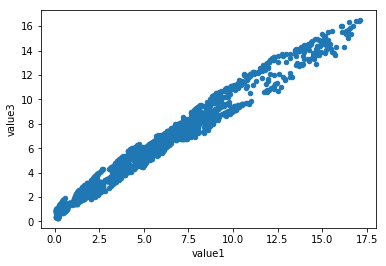

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
rates.plot(x='value1', y='value3', kind='scatter')
plt.show()
# plot of 1 year rate (x axis) vs 3 year rate

In [8]:
rates['const'] = 1
rates = rates.dropna()

In [9]:
# OLS regression of one year rate on three year rate
reg1 = sm.OLS(endog=rates['value3'], exog=rates[['const', 'value1']], missing='drop')
results= reg1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 value3   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 1.252e+05
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:54:36   Log-Likelihood:                -2162.4
No. Observations:                2998   AIC:                             4329.
Df Residuals:                    2996   BIC:                             4341.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6940      0.016     42.121      0.0

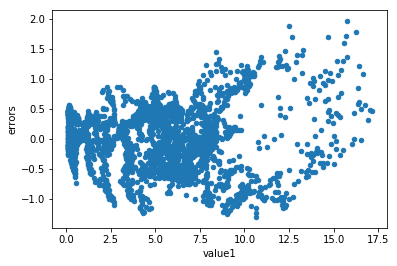

In [10]:
# look to see if standard errors are correlated w/ our endogenous variable
rates['errors'] = results.predict() - rates['value3']
rates.plot(x='value1', y='errors', kind='scatter')
plt.show()
# they are slightly correlated

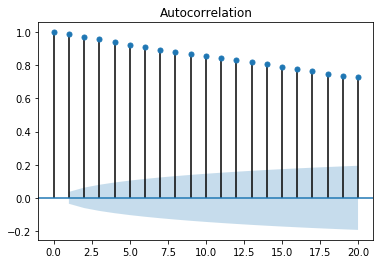

In [11]:
# check autocorrelation of the errors: this would suggest it behaves like a random walk, which is very bad
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(rates['errors'], lags = 20)
plt.show()

In [12]:
# take first difference of each time series. maybe this will yield better results
rates['1diff'] = rates['value1'].diff()
rates['3diff'] = rates['value3'].diff()

In [13]:
reg1 = sm.OLS(endog=rates['3diff'], exog=rates[['1diff']], missing='drop')
results= reg1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  3diff   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                 1.266e+04
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:54:37   Log-Likelihood:                 3867.8
No. Observations:                2997   AIC:                            -7734.
Df Residuals:                    2996   BIC:                            -7727.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1diff          0.7948      0.007    112.519      0.0

In [14]:
rates['differrors'] = results.predict() - rates['3diff'].dropna()

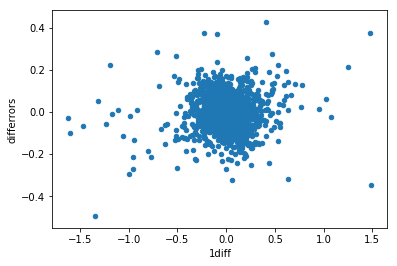

In [15]:
# error term not very correlated w/ exogenous variable now, this is good
rates.plot(x='1diff', y='differrors', kind='scatter')
plt.show()

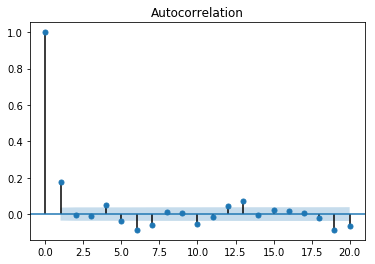

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(rates['differrors'].dropna(), lags = 20)
plt.show()
# autocorrelation function is much more managable this time. We can use an ARMA model on our errors. 

In [17]:
# simple MA model that we run on our error term. 
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(rates['differrors'].dropna(), order=(0,0,1), freq = 'W-FRI')
model_fit = model.fit(disp=0, trend = 'nc')
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             differrors   No. Observations:                 2997
Model:                     ARMA(0, 1)   Log Likelihood                3918.220
Method:                       css-mle   S.D. of innovations              0.065
Date:                Sun, 23 Jun 2019   AIC                          -7832.440
Time:                        22:54:37   BIC                          -7820.429
Sample:                    01-12-1962   HQIC                         -7828.120
                         - 06-14-2019                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ma.L1.differrors     0.1839      0.018     10.389      0.000       0.149       0.219
                                    Roots                                    
                  Real          Ima

In [32]:
# figure out final model (messy and just gets coefficient, not R^2). turns out coeff is basically the same.
rates['shiftdifferrors'] = rates['differrors'].shift(1)
rates['3diffnorm'] = rates['3diff'] - .1839 * rates['differrors']

In [34]:
# final regression model
reg1 = sm.OLS(endog=rates.dropna()['3diffnorm'], exog=rates.dropna()['1diff'], missing='drop')
results= reg1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              3diffnorm   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     9030.
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        23:01:49   Log-Likelihood:                 3360.2
No. Observations:                2996   AIC:                            -6718.
Df Residuals:                    2995   BIC:                            -6712.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1diff          0.7949      0.008     95.024      0.0

In [35]:
rsq = (sum(rates['3diff'].dropna()**2) - sum(model_fit.resid**2)) / sum(rates['3diff'].dropna()**2)
rsq
# approximates our final r^2 value. 0.809 if we leave out the MA model, here 0.815

0.8149805255484717